In [1]:
import leafmap

In [58]:
url = "https://earth-search.aws.element84.com/v1/"
collection = "sentinel-2-l2a"
# collection = "landsat-c2-l2"
time_range = "2020-08-01/2020-08-31"

In [59]:
# bbox for dallas metro
# bbox = [-97.65, 32.464, -96.378, 33.291]
# bbox = [-97.71580426534852, 32.46145032218057, -96.35291477421039, 33.40303473839707]
bbox = [
    -97.06213756027009,
    32.97324551867027,
    -96.46807822577594,
    33.3578329610085,
]

In [61]:
search = leafmap.stac_search(
    url=url,
    max_items=10,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 20}},
    sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
    get_links=True,
)
search

['https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SQB_20200819_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPC_20200809_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SQB_20200829_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPB_20200829_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SQC_20200809_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPB_20200819_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPC_20200822_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPC_20200822_0_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPB_20200809_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel

In [102]:
search_gdf = leafmap.stac_search(
    url=url,
    max_items=10,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 20}},
    sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
    get_gdf=True,
    # get_links=True,
)

In [103]:
search_gdf.columns  # ["search_gdf"].value_counts()

Index(['geometry', 'created', 'platform', 'constellation', 'instruments',
       'eo:cloud_cover', 'proj:epsg', 'mgrs:utm_zone', 'mgrs:latitude_band',
       'mgrs:grid_square', 'grid:code', 'view:sun_azimuth',
       'view:sun_elevation', 's2:degraded_msi_data_percentage',
       's2:nodata_pixel_percentage', 's2:saturated_defective_pixel_percentage',
       's2:dark_features_percentage', 's2:cloud_shadow_percentage',
       's2:vegetation_percentage', 's2:not_vegetated_percentage',
       's2:water_percentage', 's2:unclassified_percentage',
       's2:medium_proba_clouds_percentage', 's2:high_proba_clouds_percentage',
       's2:thin_cirrus_percentage', 's2:snow_ice_percentage',
       's2:product_type', 's2:processing_baseline', 's2:product_uri',
       's2:generation_time', 's2:datatake_id', 's2:datatake_type',
       's2:datastrip_id', 's2:granule_id', 's2:reflectance_conversion_factor',
       'datetime', 's2:sequence', 'earthsearch:s3_path',
       'earthsearch:payload_id', 'ear

<Axes: >

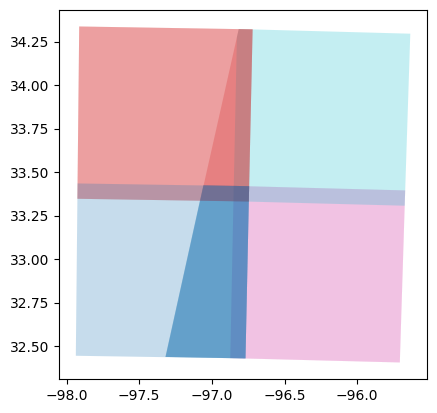

In [104]:
search_gdf.plot("mgrs:grid_square", alpha=0.25)

In [95]:
search_gdf["s2:granule_id"].value_counts()

s2:granule_id
S2A_OPER_MSI_L2A_TL_S2RP_20230510T150547_A026950_T14SQB_N05.00    1
S2A_OPER_MSI_L2A_TL_S2RP_20230422T085531_A026807_T14SPC_N05.00    1
S2A_OPER_MSI_L2A_TL_S2RP_20230423T153138_A027093_T14SQB_N05.00    1
S2A_OPER_MSI_L2A_TL_S2RP_20230423T153138_A027093_T14SPB_N05.00    1
S2A_OPER_MSI_L2A_TL_S2RP_20230422T085531_A026807_T14SQC_N05.00    1
S2A_OPER_MSI_L2A_TL_S2RP_20230510T150547_A026950_T14SPB_N05.00    1
S2A_OPER_MSI_L2A_TL_S2RP_20230320T065316_A026993_T14SPC_N05.00    1
S2A_OPER_MSI_L2A_TL_VGS1_20200822T213657_A026993_T14SPC_N02.14    1
S2A_OPER_MSI_L2A_TL_S2RP_20230422T085531_A026807_T14SPB_N05.00    1
S2A_OPER_MSI_L2A_TL_S2RP_20230508T205105_A026850_T14SPB_N05.00    1
Name: count, dtype: int64

In [107]:
search_gdf["area"] = search_gdf.geometry.area

In [117]:
search_gdf.sort_values("area", ascending=False, inplace=True)

In [118]:
search_gdf

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,area
6,"POLYGON ((-97.91284 34.33683, -97.92531 33.346...",2023-07-18T18:10:32.679Z,sentinel-2a,sentinel-2,[msi],0.090464,32614,14,S,PC,...,S2A_OPER_MSI_L2A_TL_S2RP_20230320T065316_A0269...,0.976674,2020-08-22T17:24:31.557000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/862d...,True,{'sentinel2-to-stac': '0.1.1'},2023-07-18T18:10:32.679Z,1.174444
7,"POLYGON ((-97.91284 34.33683, -96.71979 34.320...",2022-11-06T14:40:51.617Z,sentinel-2a,sentinel-2,[msi],0.123832,32614,14,S,PC,...,S2A_OPER_MSI_L2A_TL_VGS1_20200822T213657_A0269...,0.976674,2020-08-22T17:24:31.557000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/8e5e...,False,{'sentinel2-to-stac': '0.1.0'},2022-11-06T14:40:51.617Z,1.174444
4,"POLYGON ((-96.81511 34.32216, -96.82786 34.275...",2023-08-27T04:29:38.525Z,sentinel-2a,sentinel-2,[msi],0.043426,32614,14,S,QC,...,S2A_OPER_MSI_L2A_TL_S2RP_20230422T085531_A0268...,0.972212,2020-08-09T17:14:32.645000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/1124...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-27T04:29:38.525Z,1.172771
9,"POLYGON ((-97.92422 33.43490, -97.93615 32.444...",2023-08-24T00:12:59.923Z,sentinel-2a,sentinel-2,[msi],0.304236,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_S2RP_20230508T205105_A0268...,0.973127,2020-08-12T17:24:46.412000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/30b4...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-24T00:12:59.923Z,1.162550
0,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-09-05T16:11:23.931Z,sentinel-2a,sentinel-2,[msi],0.004771,32614,14,S,QB,...,S2A_OPER_MSI_L2A_TL_S2RP_20230510T150547_A0269...,0.975530,2020-08-19T17:14:46.896000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/4364...,True,{'sentinel2-to-stac': '0.1.1'},2023-09-05T16:11:23.931Z,1.161135
2,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-09-05T06:04:24.560Z,sentinel-2a,sentinel-2,[msi],0.006380,32614,14,S,QB,...,S2A_OPER_MSI_L2A_TL_S2RP_20230423T153138_A0270...,0.979577,2020-08-29T17:14:46.207000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/5f07...,True,{'sentinel2-to-stac': '0.1.1'},2023-09-05T06:04:24.560Z,1.161135
3,"POLYGON ((-97.05919 33.42438, -97.31992 32.437...",2023-09-05T06:11:28.621Z,sentinel-2a,sentinel-2,[msi],0.007595,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_S2RP_20230423T153138_A0270...,0.979577,2020-08-29T17:14:48.988000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/599f...,True,{'sentinel2-to-stac': '0.1.1'},2023-09-05T06:11:28.621Z,0.429235
5,"POLYGON ((-97.05790 33.42436, -97.31928 32.437...",2023-09-05T16:07:36.681Z,sentinel-2a,sentinel-2,[msi],0.069100,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_S2RP_20230510T150547_A0269...,0.975530,2020-08-19T17:14:49.680000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ae1b...,True,{'sentinel2-to-stac': '0.1.1'},2023-09-05T16:07:36.681Z,0.428280
8,"POLYGON ((-97.05726 33.42435, -97.31801 32.437...",2023-08-27T04:35:14.364Z,sentinel-2a,sentinel-2,[msi],0.149486,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_S2RP_20230422T085531_A0268...,0.972212,2020-08-09T17:14:49.916000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/255a...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-27T04:35:14.364Z,0.427329
1,"POLYGON ((-96.81511 34.32216, -97.08048 33.336...",2023-08-27T04:45:26.105Z,sentinel-2a,sentinel-2,[msi],0.006121,32614,14,S,PC,...,S2A_OPER_MS

In [119]:
search_gdf.drop_duplicates("mgrs:grid_square", inplace=True)

<Axes: >

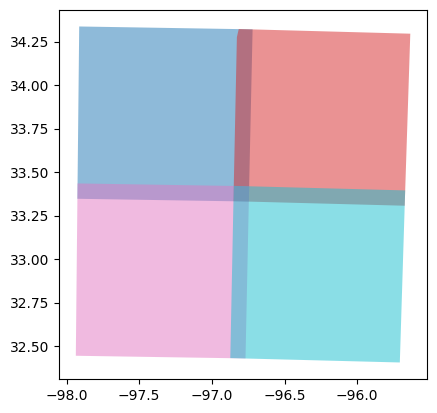

In [125]:
search_gdf.iloc[0:4].plot("s2:granule_id", alpha=0.5)

In [132]:
# # create a query searching for unique datastrip ids based on the above
q = {"s2:granule_id": {"in": search_gdf["s2:granule_id"].iloc[0:4].unique().tolist()}}

search_gdf2 = leafmap.stac_search(
    url=url,
    max_items=4,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query=q,
    # sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
    get_gdf=True,
    # get_links=True,
)

In [133]:
search_gdf2

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((-97.91284 34.33683, -97.92531 33.346...",2023-07-18T18:10:32.679Z,sentinel-2a,sentinel-2,[msi],0.090464,32614,14,S,PC,...,S2A_OPER_MSI_L2A_DS_S2RP_20230320T065316_S2020...,S2A_OPER_MSI_L2A_TL_S2RP_20230320T065316_A0269...,0.976674,2020-08-22T17:24:31.557000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/862d...,True,{'sentinel2-to-stac': '0.1.1'},2023-07-18T18:10:32.679Z
1,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-09-05T16:11:23.931Z,sentinel-2a,sentinel-2,[msi],0.004771,32614,14,S,QB,...,S2A_OPER_MSI_L2A_DS_S2RP_20230510T150547_S2020...,S2A_OPER_MSI_L2A_TL_S2RP_20230510T150547_A0269...,0.975530,2020-08-19T17:14:46.896000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/4364...,True,{'sentinel2-to-stac': '0.1.1'},2023-09-05T16:11:23.931Z
2,"POLYGON ((-97.92422 33.43490, -97.93615 32.444...",2023-08-24T00:12:59.923Z,sentinel-2a,sentinel-2,[msi],0.304236,32614,14,S,PB,...,S2A_OPER_MSI_L2A_DS_S2RP_20230508T205105_S2020...,S2A_OPER_MSI_L2A_TL_S2RP_20230508T205105_A0268...,0.973127,2020-08-12T17:24:46.412000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/30b4...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-24T00:12:59.923Z
3,"POLYGON ((-96.81511 34.32216, -96.82786 34.275...",2023-08-27T04:29:38.525Z,sentinel-2a,sentinel-2,[msi],0.043426,32614,14,S,QC,...,S2A_OPER_MSI_L2A_DS_S2RP_20230422T085531_S2020...,S2A_OPER_MSI_L2A_TL_S2RP_20230422T085531_A0268...,0.972212,2020-08-09T17:14:32.645000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/1124...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-27T04:29:38.525Z


<Axes: >

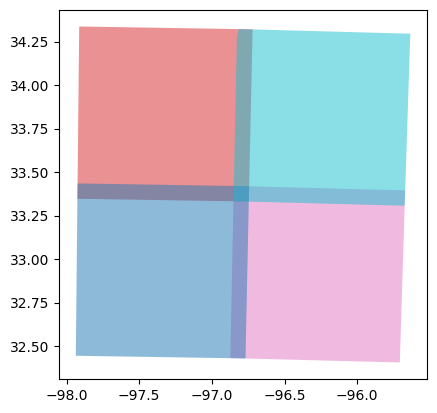

In [134]:
search_gdf2.plot("mgrs:grid_square", alpha=0.5)

In [82]:
search

['https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SQB_20200819_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPC_20200809_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SQB_20200829_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPB_20200829_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SQC_20200809_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPB_20200819_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPC_20200822_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPC_20200822_0_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPB_20200809_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel

In [135]:
search_gdf2 = leafmap.stac_search(
    url=url,
    max_items=4,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query=q,
    get_links=True,
)

In [136]:
search_gdf2

['https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPC_20200822_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SQB_20200819_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SPB_20200812_1_L2A',
 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_14SQC_20200809_1_L2A']

In [138]:
m = leafmap.Map()

for layer in search_gdf2:
    m.add_stac_layer(
        layer,
        bands=["nir", "red", "green"],
    )
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [6]:
m = leafmap.Map()
images = "landsat"
m.add_time_slider(
    search,
    time_interval=0.5,
    position="bottomright",
    band=[1, 2, 3],
    zoom_to_layer=True,
)
m

IndexError: list index out of range